## Imports

In [7]:
# Standard
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Data

In [8]:
file_name = 'train_gb'
train = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

file_name = 'test_gb'
test = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

In [9]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis = 1)
y = train['Loan_Status']
print(X.head())
print(y.head())

     Gender  Married Dependents  Education  Self_Employed  Credit_History  \
205       0        0          0          1              0             1.0   
238       0        0          1          0              0             1.0   
25        1        1          0          0              1             1.0   
527       1        1          1          1              0             0.0   
256       1        0          0          1              0             0.0   

     Property_Area  TotalIncome       EMI  BalanceIncome  
205              1       4408.0  0.333333    4407.666667  
238              0       3812.0  0.311111    3811.688889  
25               1       9560.0  0.530556    9559.469444  
527              1       6715.0  0.447222    6714.552778  
256              0       6045.0  0.319444    6044.680556  
205    1
238    1
25     1
527    1
256    0
Name: Loan_Status, dtype: int32


In [10]:
y.value_counts()

Loan_Status
1    304
0    143
Name: count, dtype: int64

## Hyper-parameter training Extra Trees

In [11]:
# Find the Best Model
param_grid = {
    'n_estimators': [_ for _ in range(100, 501, 100)],
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [.1, .25, .3, .35],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [4, 8],
    'min_samples_leaf' : [_ for _ in range(3, 5)]
}

grid_search = GridSearchCV(ExtraTreesClassifier(bootstrap=True, class_weight='balanced_subsample', oob_score=True), param_grid=param_grid, cv=5,scoring='f1_weighted', verbose=5, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5,
             estimator=ExtraTreesClassifier(bootstrap=True,
                                            class_weight='balanced_subsample',
                                            oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.1, 0.25, 0.3, 0.35],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 8],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1_weighted', verbose=5)

In [12]:
grid_search.best_params_

{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.1,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

## Bagging

In [13]:
base_model = grid_search.best_estimator_

In [14]:
r = random.randint(1, 101)
model = BaggingClassifier(estimator=base_model, n_estimators=200, bootstrap_features=True, random_state=r, n_jobs=-1)

In [15]:
model.fit(X, y)

BaggingClassifier(bootstrap_features=True,
                  estimator=ExtraTreesClassifier(bootstrap=True,
                                                 class_weight='balanced_subsample',
                                                 min_impurity_decrease=0.1,
                                                 min_samples_leaf=3,
                                                 min_samples_split=4,
                                                 oob_score=True),
                  n_estimators=200, n_jobs=-1, random_state=42)

## Scoring

In [16]:
X_test, y_test = test.drop(columns=['Loan_ID', 'Loan_Status']), test['Loan_Status']

In [17]:
y_pred = model.predict(X_test)

In [18]:
f1_score(y_pred = y_pred, y_true=y_test)

0.8925619834710745

In [19]:
accuracy_score(y_pred = y_pred, y_true=y_test)

0.8311688311688312

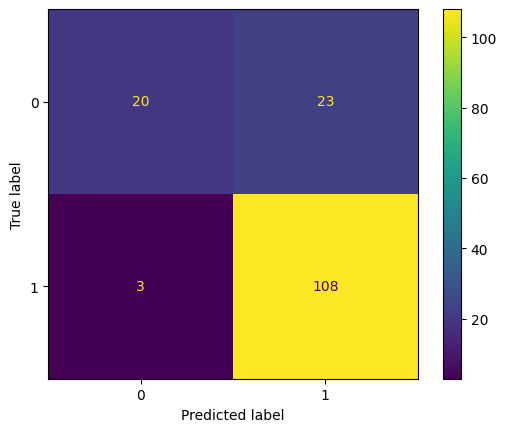

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred = y_pred, y_true=y_test), display_labels=model.classes_)
disp.plot()
plt.show()